# <center> Voter model with zealots for social opinion evolution

This is the python code used to produce the plots in <i>Voter model with zealots for social opinion evolution</i>. We follow the paper organisation. Parameters are set to the one used in the paper but are free to change. Custom functions for our simulations are in `util.py`.

We import the requested modules and set up some parameters for the plots appearance.

In [1]:
# imports
import sys
import numpy as np
from time import time
from scipy.stats import norm
from scipy.linalg import expm
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# our functions for simulations
import util

# for confidence intervals
quant = norm().ppf(0.95)

# for plots appearance
color = ["blue", "red", "green", "orange", "pink"]
letter = "abcdefghijklmnopqrstuvwxyz"
marker = "x+*^p"
linestyle = ["--", "-.", ":", "-", (0,(3, 5, 1, 5))] # last one is dashdotdotted from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html

# latex rendering
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)

In [2]:
del util
import util

Model and simulation parameters.

In [3]:
n = 100
N1_init = np.array([25,75])
S = [(10,5), (20,25)]
n_simu = 1000
max_time = 40
spacing_simu = 2
seed = None
k_range_eps = range(2,6)
Epsilon = np.array([10**(-k) for k in k_range_eps]) 
spacing_mix = .1
length = int(np.floor(max_time/spacing_simu)+1)

Simulate using custom function from `util.py`. Results will be used for both figures.

In [4]:
N1t = np.zeros((n_simu, N1_init.size, len(S), length))
start = time()

for j,(s0,s1) in enumerate(S):
    for i,n1 in enumerate(N1_init):
        for k in range(n_simu):
            sys.stdout.flush()
            sys.stdout.write("n1={}, s1={}, s0={}. Simu {}/{}. Elapsed time {}\r".format(n1, s1, s0, k+1, n_simu, round(time()-start,1)))
            N1t[k,i,j,:] = util.voter_simu(n, n1, s1, s0, max_time, spacing_simu, seed)

Compute transition rate matrix $Q$ from system (2) in the paper. The function is coded in util.

In [5]:
Q = {j: util.Qmatrix(n,s0,s1) for j,(s0,s1) in enumerate(S)}

Compute theoretical values for $\mathbb{E}N_1^{(t)}$ (`expect["markov"]`) using Theorem 2 and values from Ref.[19] (On the role of zealotry...) eq5 (`expect["ref19"]`).

In [6]:
x_axis = np.linspace(0, max_time, length)
expect = {"markov":np.zeros((N1_init.size, len(S), length)), "ref19":np.zeros((N1_init.size, len(S), length))}

for j,(s0,s1) in enumerate(S):
    s = s0+s1
    for c,t in enumerate(x_axis):
        Pt = expm(t*Q[j])
        k_range = np.arange(s1,n-s0+1)
        for i,n1 in enumerate(N1_init):
            expect["markov"][i,j,c] = k_range.dot(Pt[n1-s1,:])
            expect["ref19"][i,j,c] = s1 + s1*(n-s)/s + (n1-s1 - s1*(n-s)/s) * np.exp(-s/n*t) # ref19

Compare our `expectation` (our results) with `ref19` (results using formula from [19] (On the role of zealotry...) eq5.)

In [7]:
Mean, Min, Max = list(), list(), list()
for j,(s0,s1) in enumerate(S):
    print("(s0,s1) = {}".format(s0,s1))
    for i,n1 in enumerate(N1_init):
        print("\tn1 = {}".format(n1))
        diff = np.abs(expect["ref19"][i,j]-expect["markov"][i,j])
        print("\t\tmax = {:.4f}, min = {:.4f}, mean = {:.4f}, median = {:.4f}".format(np.max(diff), np.min(diff), np.mean(diff), np.median(diff)))
        Mean.append(np.mean(diff))
        Min.append(np.min(diff))
        Max.append(np.max(diff))
print("Overall: mean {} min {} max {}".format(np.mean(Mean), min(Min), max(Max)))

(s0,s1) = 10
	n1 = 25
		max = 0.0307, min = 0.0000, mean = 0.0129, median = 0.0101
	n1 = 75
		max = 0.1533, min = 0.0000, mean = 0.0647, median = 0.0504
(s0,s1) = 20
	n1 = 25
		max = 0.1124, min = 0.0000, mean = 0.0151, median = 0.0001
	n1 = 75
		max = 0.0715, min = 0.0000, mean = 0.0096, median = 0.0001
Overall: mean 0.025578380202105972 min 0.0 max 0.1533057588108946


Compute mixing times.

In [8]:
mixing = np.zeros((Epsilon.size, N1_init.size, len(S)))
start = time()
for j,(s0,s1) in enumerate(S):
    pi = util.stationary(n,s0,s1,Q[j])
    for i,n1 in enumerate(N1_init):
        for k,eps in enumerate(Epsilon):
            sys.stdout.flush()
            sys.stdout.write("S {}/{}. eps {}/{}. n1 {}/{}. Elapsed time {}\r"
                             .format(j+1, len(S), k+1, Epsilon.size, j+1, N1_init.size, round(time()-start,1)))
            mixing[k,i,j] = util.mixing_time(n, n1, s0, s1, Q[j], pi, eps, spacing_mix)

Plot Figure 1: empirical vs theoretical distributions vs stationary at different chosen points in time.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


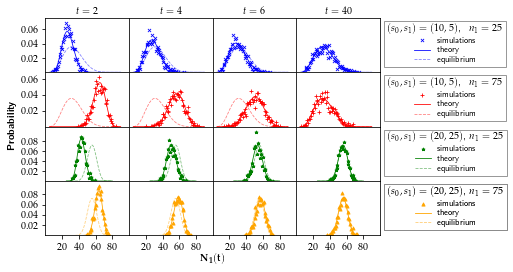

In [9]:
n_cases = len(S)*N1_init.size
fs = 10 # fontsize 
timestamp = [2,4,6,40]
time_index = [int(t/spacing_simu) for t in timestamp]
unique_emp, probs_emp, distrib_theo, steady, ref19 = dict(), dict(), dict(), dict(), dict() # distrib empirical, theoretical, stationary

# first, compute distribs and determine upper limit of y-axis, ie maximum proba
# also compute errors
ymax = [-1]*n_cases
c = 0 # counter for axes indices
for j,(s0,s1) in enumerate(S):
    for i,n1 in enumerate(N1_init):
        steady[j,i] = util.stationary(n,s0,s1,Q[j]) # stationary
        for k,t in enumerate(timestamp):
            tt = time_index[k]
            unique_emp[j,i,k], count = np.unique(N1t[:,i,j,tt], return_counts=True)
            probs_emp[j,i,k] = count/count.sum() # transform counts into proportions
            distrib_theo[j,i,k] = expm(t*Q[j])[n1-s1,:] # theoretical
            ymax[c] = max([ymax[c], probs_emp[j,i,k].max(), distrib_theo[j,i,k].max(), steady[j,i].max()])
        ymax[c] = 1.1*ymax[c] # add 10% for extra padding
        c += 1 # increment counter

# then plot
fig, ax = plt.subplots(n_cases, len(timestamp))
fig.subplots_adjust(hspace=0, wspace=0)
c = 0 # counter for axes indices and appearance of plots
for j,(s0,s1) in enumerate(S):
    for i,n1 in enumerate(N1_init):
        for k,t in enumerate(timestamp):
            
            # plot
            scatter = ax[c,k].scatter(unique_emp[j,i,k], probs_emp[j,i,k], linewidth=.8, s=10, marker=marker[c], color=color[c])
            plot_steady, = ax[c,k].plot(range(s1, n-s0+1), steady[j,i], color=color[c], ls="--", linewidth=.8, alpha=.5)
            plot_theo, = ax[c,k].plot(range(s1, n-s0+1), distrib_theo[j,i,k], color=color[c], linewidth=.8)

            # ticks and appearance
            #ax[c,k].grid()
            ax[c,k].set_xlim(0,n)
            ax[c,k].set_ylim(0,ymax[c])
            if c==0:
                ax[c,k].set_xlabel("$t = {}$".format(t), fontsize=fs)
                ax[c,k].xaxis.set_label_position("top") 
            if c==1 and k==0:
                ax[c,k].set_ylabel(r"\textbf{Probability}", fontsize=fs)#, rotation=0)
                ax[c,k].yaxis.set_label_coords(-0.35, 0)
                #ax[c,k].yaxis.set_label_position("right") 
            if c==3 and k==2:
                ax[c,k].set_xlabel(r"$\mathbf{N_1(t)}$", fontsize=fs)
                ax[c,k].xaxis.set_label_coords(0, -.35)
            if k==0 and c<3:
                ax[c,k].tick_params(axis="x", which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
            if k>0 and c<3:
                ax[c,k].tick_params(axis="both", which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
            ax[c,k].set_xticks((20,40,60,80))
            if k>0:
                ax[c,k].tick_params(axis="y", which='both', bottom=False, top=False, left=False, right=False, labelleft=False) # no y-ticks
            if c>1:
                ax[c,k].set_yticks((0.02,0.04,0.06,0.08))
            else:
                ax[c,k].set_yticks((0.02,0.04,0.06))
                
        # legend 
        loc = (1.05, 3.1-c)
        elements = [scatter, plot_theo, plot_steady]
        names = ["simulations", "theory", "equilibrium"]
        if c<2: # differentiate so we can add extra space for the boxes to be all the same size
            title = "$(s_0,s_1) = ({},{})$, $\;\,n_1 = {}$".format(s0,s1,n1)
        else:
            title="$(s_0,s_1) = ({},{})$, $n_1 = {}$".format(s0,s1,n1)
        legend = plt.legend(elements, names, title=title, loc=loc, fancybox=False, labelspacing=.1, edgecolor="grey", fontsize=8)
        plt.gca().add_artist(legend)
            
        # increment counter
        c += 1
        
#plt.tight_layout()
#plt.savefig("N1t_distrib_nsimu={}_maxtime={}.pdf".format(n_simu, max_time), bbox_inches="tight")
plt.show()
plt.close()

Plot Figure 2: $\mathbb{E}N_1^{(t)}$, theoretical values and empirical averages with confidence intervals, and theoretical mixing times. Also plot values from Ref.[19].

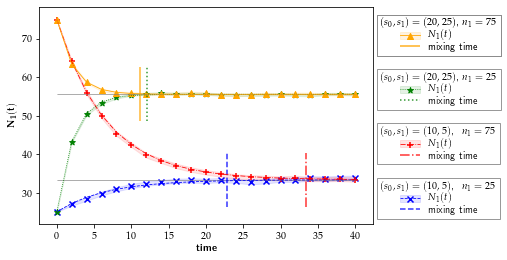

In [10]:
eps_bar_height = 7
count = -1

# plot
for j,(s0,s1) in enumerate(S):
    
    for i,n1 in enumerate(N1_init):
        count += 1
        mean = np.mean(N1t[:,i,j,:], axis=0)
        std = np.std(N1t[:,i,j,:], axis=0, ddof=1)
        fill_btw = plt.fill_between(x_axis, mean-quant*std/np.sqrt(n_simu), mean+quant*std/np.sqrt(n_simu), alpha=.1, color=color[count])
        plot, = plt.plot(x_axis, expect["markov"][i,j], c=color[count], ls=linestyle[count], linewidth=.8)
        scatter = plt.scatter(x_axis, mean, c=color[count], marker=marker[count], label="n1 = {}".format(str(n1)))
        
        # limit and mixing time and limit
        limit = n*s1/(s0+s1)
        hline = plt.hlines(limit, 0, max_time, color="grey", alpha=.5, linewidth=.8)
        for k,eps in enumerate(Epsilon):
            if k>0: # we choose to only represent the lowest mixing times
                break
            mix = mixing[k,i,j]
            if mix<max_time: # don't plot mixing times further than what was simulated
                mix_line = plt.vlines(mixing[k,i,j], limit-eps_bar_height, limit+eps_bar_height, ls=linestyle[count], color=color[count], alpha=.8)
     
        # legend 
        loc = (1.01, 0.025+count/4)
        elements = [(fill_btw, plot, scatter), mix_line]
        names = ["$N_1(t)$", "mixing time"]
        if count<2: # differentiate so we can add extra space for the boxes to be all the same size
            title = "$(s_0,s_1) = ({},{})$, $\;\,n_1 = {}$".format(s0,s1,n1)
        else:
            title = "$(s_0,s_1) = ({},{})$, $n_1 = {}$".format(s0,s1,n1)
        legend = plt.legend(elements, names, title=title, loc=loc, fancybox=False, labelspacing=.1, edgecolor="grey")
        plt.gca().add_artist(legend)
        
# save
plt.xlabel(r"\textbf{time}")
plt.ylabel(r"$\mathbf{N_1(t)}$")
#plt.savefig("N1t_mixing_n={}_nsimu={}_maxtime={}.pdf".format(n, n_simu, max_time), bbox_inches="tight")
plt.show()
plt.close()

Compute relative errors.

In [11]:
error_abs, totalvar = list(), list()
for j,(s0,s1) in enumerate(S):
    for i,n1 in enumerate(N1_init):
        for k,t in enumerate(timestamp):
            tt = time_index[k]
            unique_emp[j,i,k], count = np.unique(N1t[:,i,j,tt], return_counts=True)
            probs_emp[j,i,k] = count/count.sum() # transform counts into proportions
            distrib_theo[j,i,k] = expm(t*Q[j])[n1-s1,:] # theoretical
            totalvar_tmp = 0
            for l,x in enumerate(range(s1, n-s0+1)):
                if x not in unique_emp[j,i,k]:
                    error_abs.append(distrib_theo[j,i,k][l])
                    totalvar_tmp += distrib_theo[j,i,k][l]
                else:
                    index = np.where(unique_emp[j,i,k]==x)[0][0]
                    diff = np.abs(distrib_theo[j,i,k][l]-probs_emp[j,i,k][index])
                    error_abs.append(diff)
                    totalvar_tmp += diff
            totalvar.append(totalvar_tmp/2)
print("Error abs: mean {}, min {}, max {}".format(np.mean(error_abs), min(error_abs), max(error_abs)))
print("Total variation: mean {}, min {}, max {}".format(np.mean(totalvar), min(totalvar), max(totalvar)))

Error abs: mean 0.0020517822865925117, min 9.540161778264844e-21, max 0.029893030909478507
Total variation: mean 0.07283827117403416, min 0.04781205958652115, max 0.10236899095952981
